# Vertex AI:Training and serving a custom model

1. Overview
2. Intro to Vertex AI
3. Setup your environment
4. Containerize training code
5. Deploy a model endpoint
6. cleanup

### 2. Intro to Vertex AI

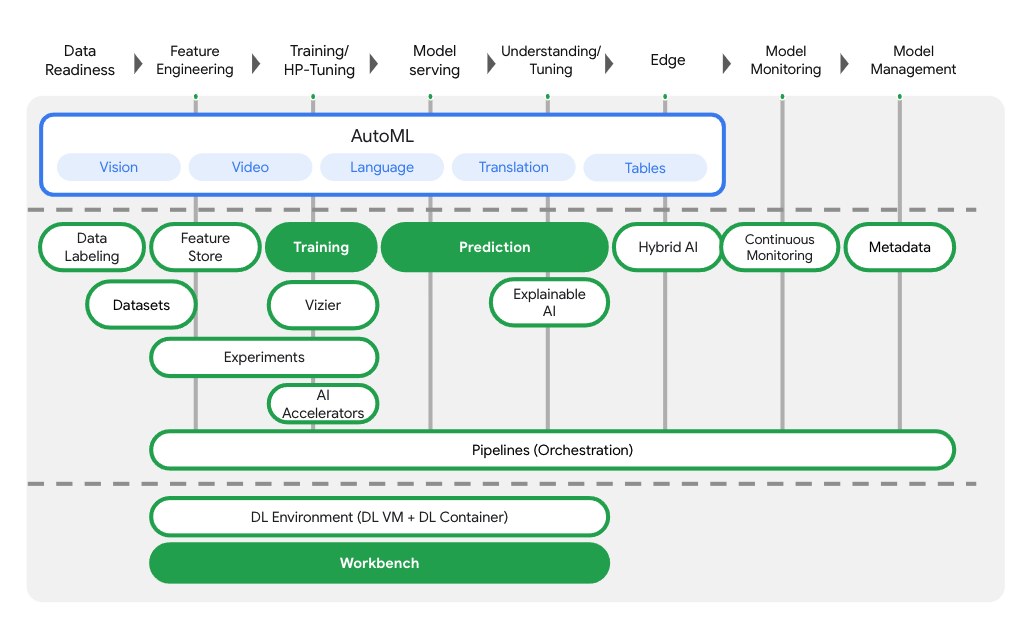

### 3. Setup your environment

##### Step 1: Enable the Compute Engine API

##### Step 2: Enable the Vertex AI API

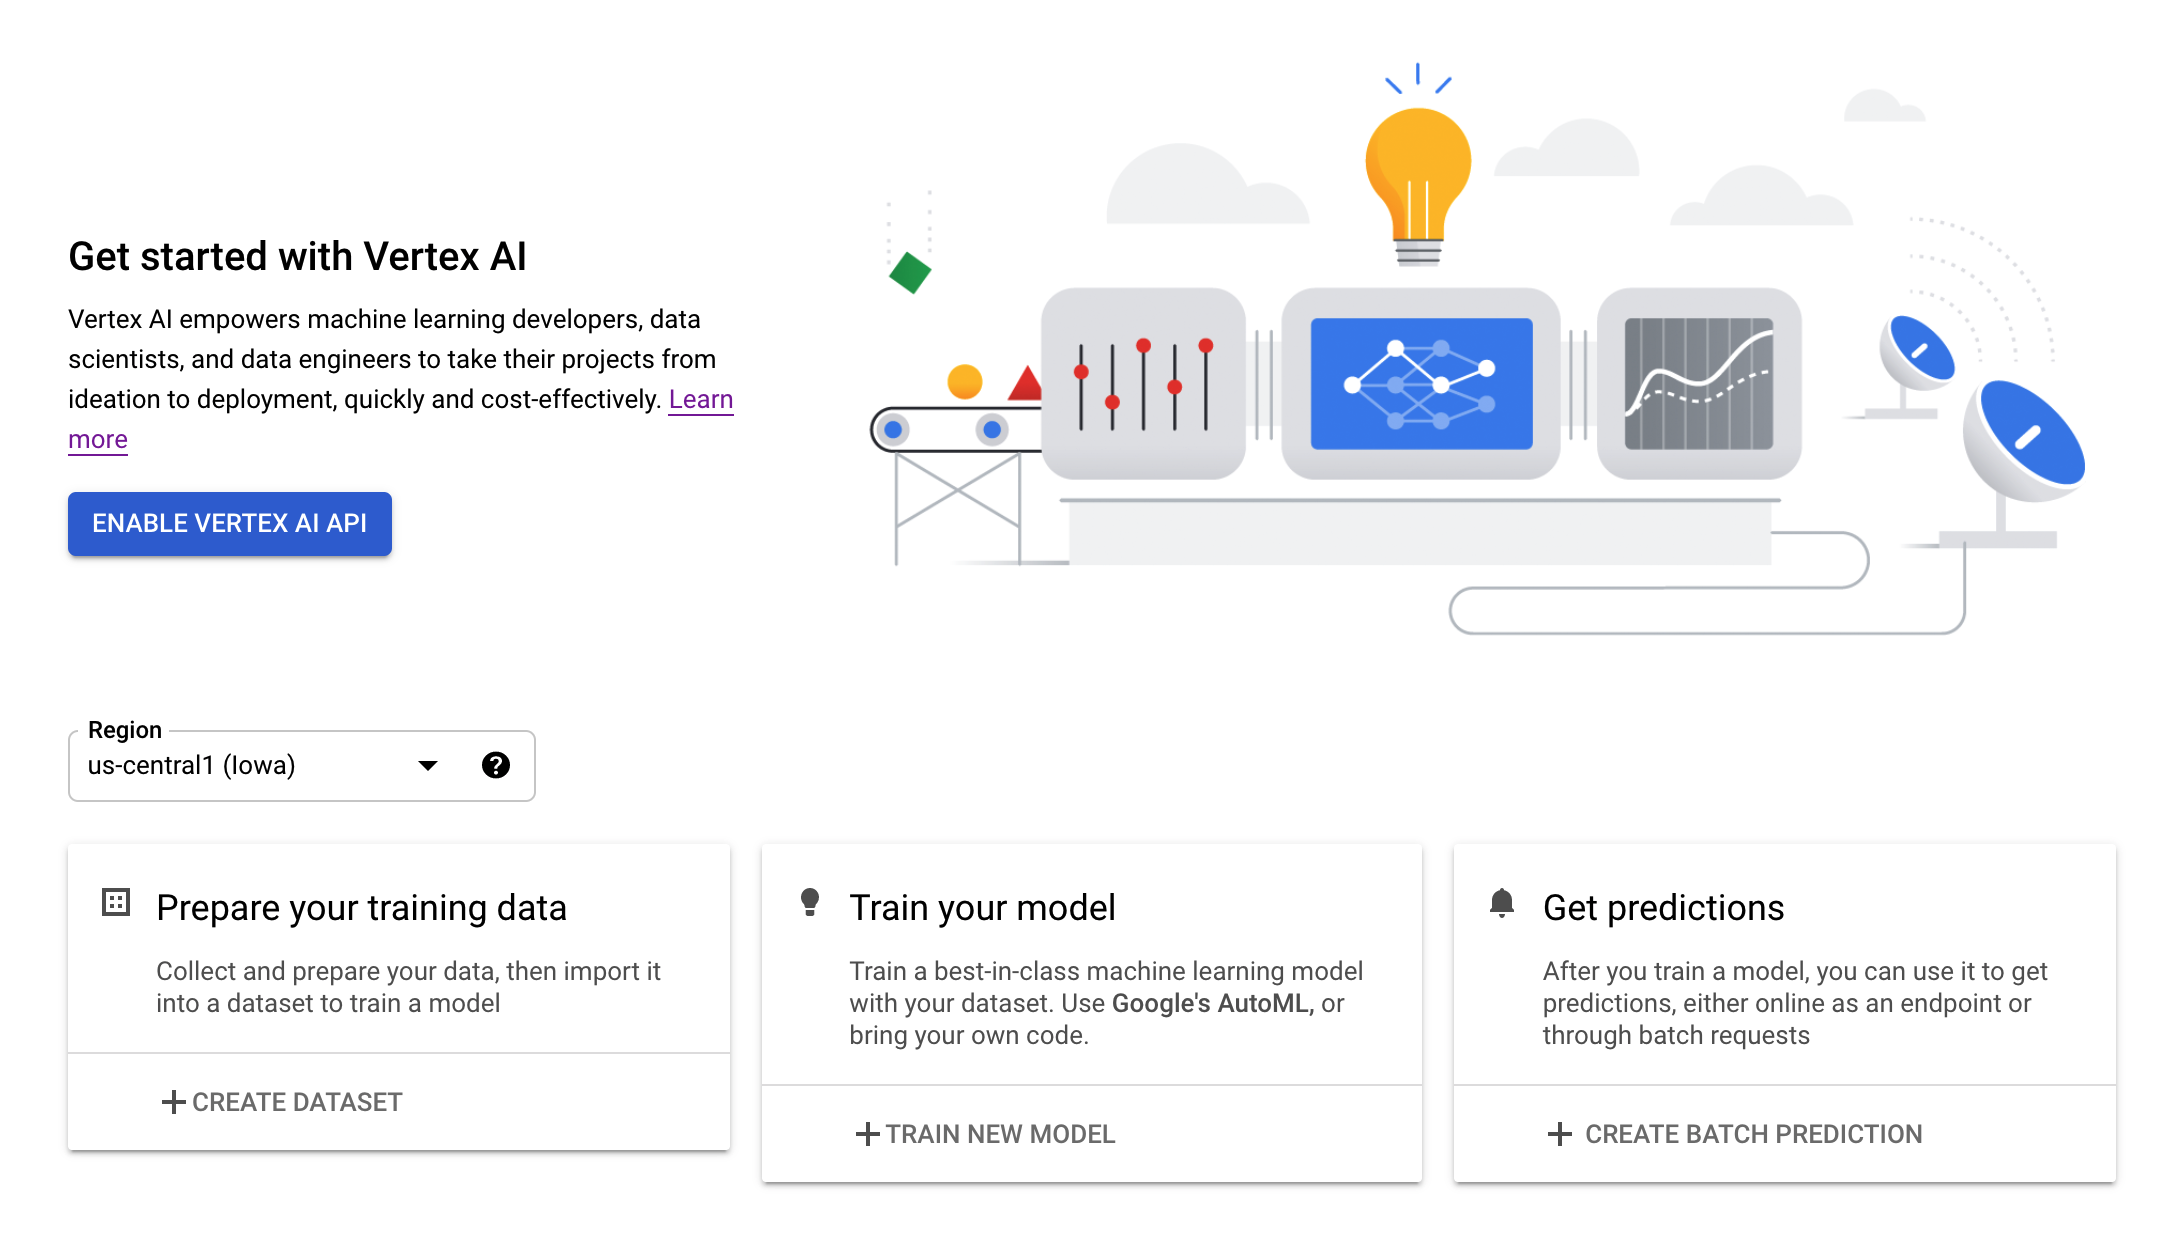

##### Step 3 : Enable the Container Registry API

##### Step 4 : Create a Vertext AI Workbench instance

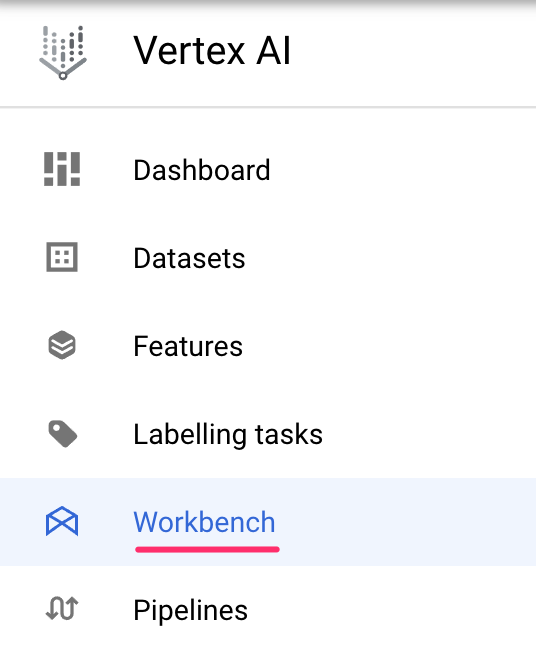



### 4. Containerize training code

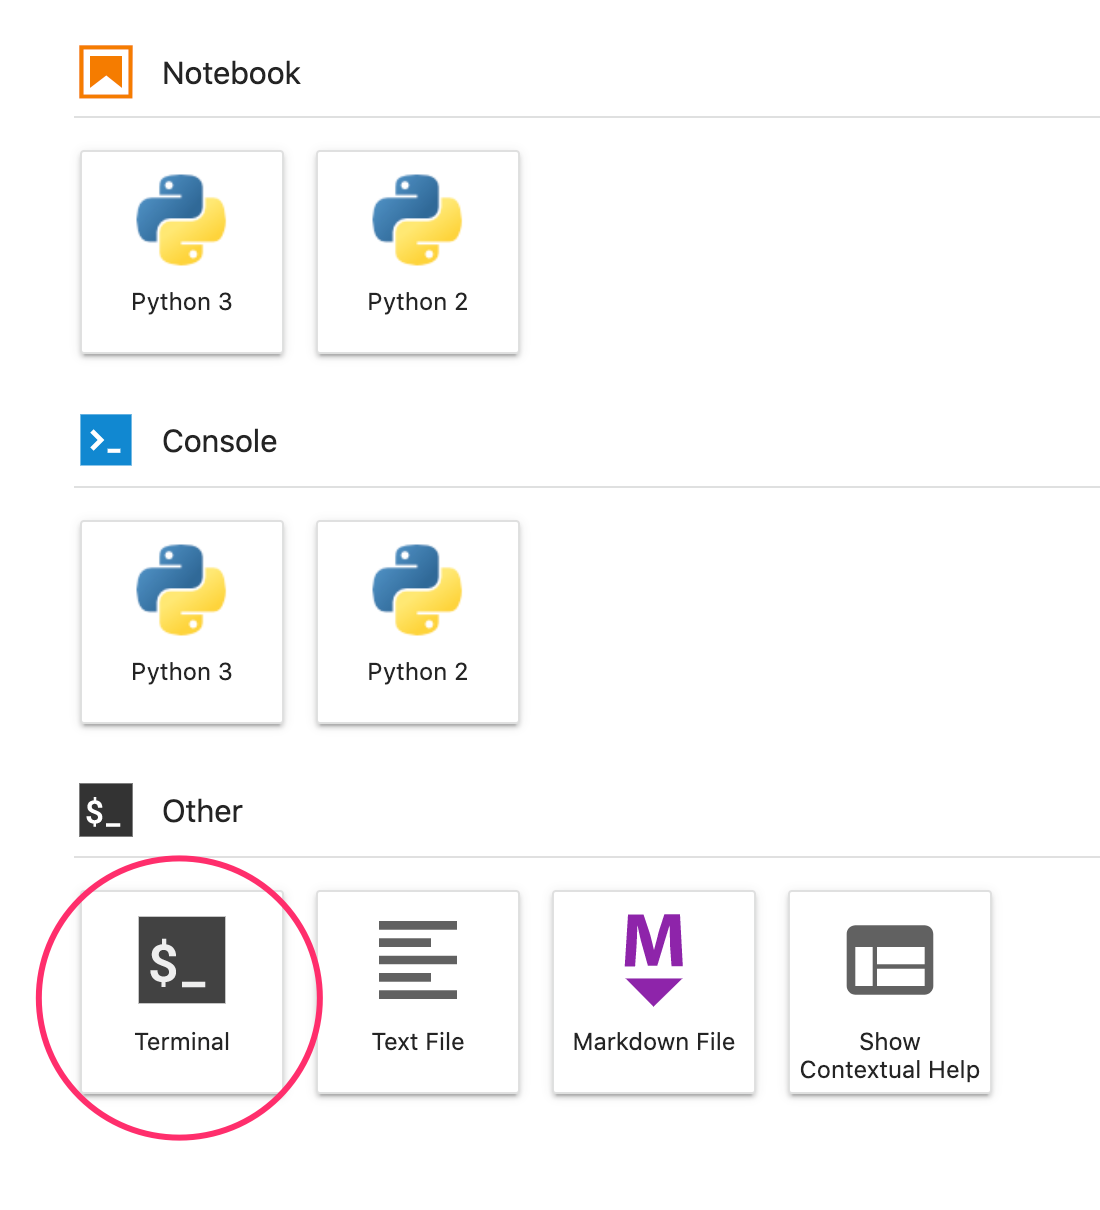

In [15]:
!mkdir mpg

In [16]:
!touch mpg/Dockerfile

Docker 파일에 다음의 내용을 추가

```Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-6
WORKDIR /

# Copies the trainer code to the docker image.
COPY trainer /trainer

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.train"]
```

##### Step 2: Create a Cloud Storage bucket

터미널에서 cloud storage 버킷 생성

```bash
PROJECT_ID='your-cloud-project'
BUCKET_NAME="gs://${PROJECT_ID}-bucket"
gsutil mb -l us-central1 $BUCKET_NAME
```

##### Step 3: Add model training code

터미널에서 다음의 디렉토리와 파일 생성

```bash
mkdir trainer
touch trainer/train.py
```

train.py 파일에 다음의 내용을 추가

```python
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

"""## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Get the data
First download the dataset.
"""

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

"""Import it using pandas"""

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

# TODO: replace `your-gcs-bucket` with the name of the Storage bucket you created earlier
BUCKET = 'gs://your-gcs-bucket'

"""### Clean the data

The dataset contains a few unknown values.
"""

dataset.isna().sum()

"""To keep this initial tutorial simple drop those rows."""

dataset = dataset.dropna()

"""The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:"""

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

"""### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.
"""

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

"""### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Also look at the overall statistics:
"""

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

"""### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.
"""

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

"""### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.
"""

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

"""This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.
"""

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

"""### Inspect the model

Use the `.summary` method to print a simple description of the model
"""

model.summary()

"""Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

Visualize the model's training progress using the stats stored in the `history` object.

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).
"""

model = build_model()

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    callbacks=[early_stop])


# Export model and save to GCS
model.save(BUCKET + '/mpg/model')
```

##### Step 4: Build and test the container locally

터미널에서 다음의 명령어 수행

```bash
IMAGE_URI="gcr.io/$PROJECT_ID/mpg:v1"
docker build ./ -t $IMAGE_URI
docker run $IMAGE_URI
docker push $IMAGE_URI
```

### 5. Run a training job on Vertex AI

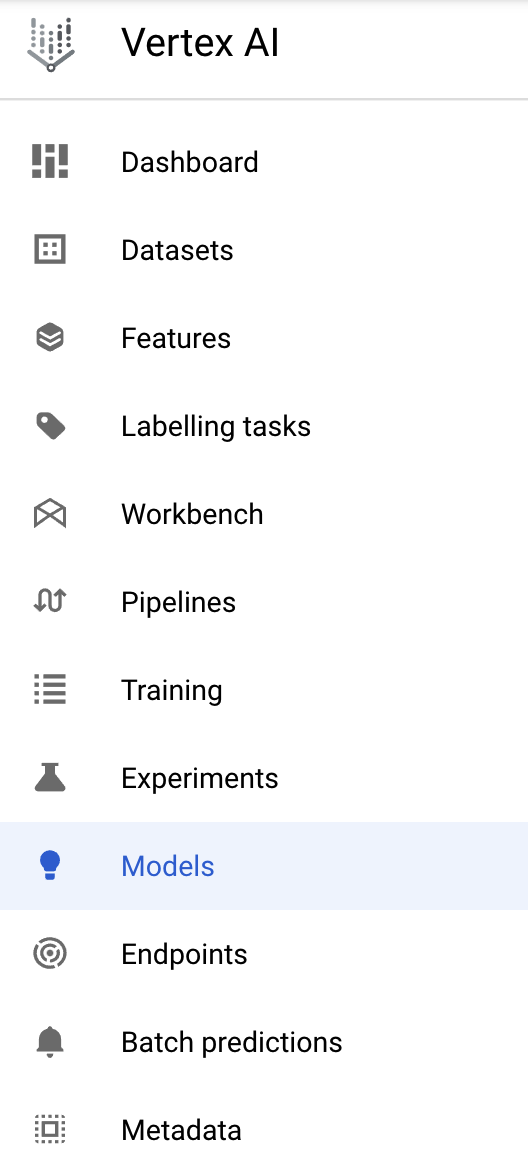

##### gcloud를 사용한 모델 생성


```bash
gcloud ai custom-jobs create \
  --region=us-central1 \
  --display-name=mpg \
  --worker-pool-spec="machine-type=n1-standard-4,replica-count=1,executor-image-uri=CONTAINER_REGISTRY,local-package-path=.,python-module=trainer.train"
  
  
# gcr.io/henrymj-int-XXXXXXX/mpg@sha256:9722933a9f00b5c3e4547503sdfkjlskdfj8cb8e8cdc8ddf55b3eff5b70
```

### 6. Deploy a model endpoint

##### Step 1: Deploy endpoint

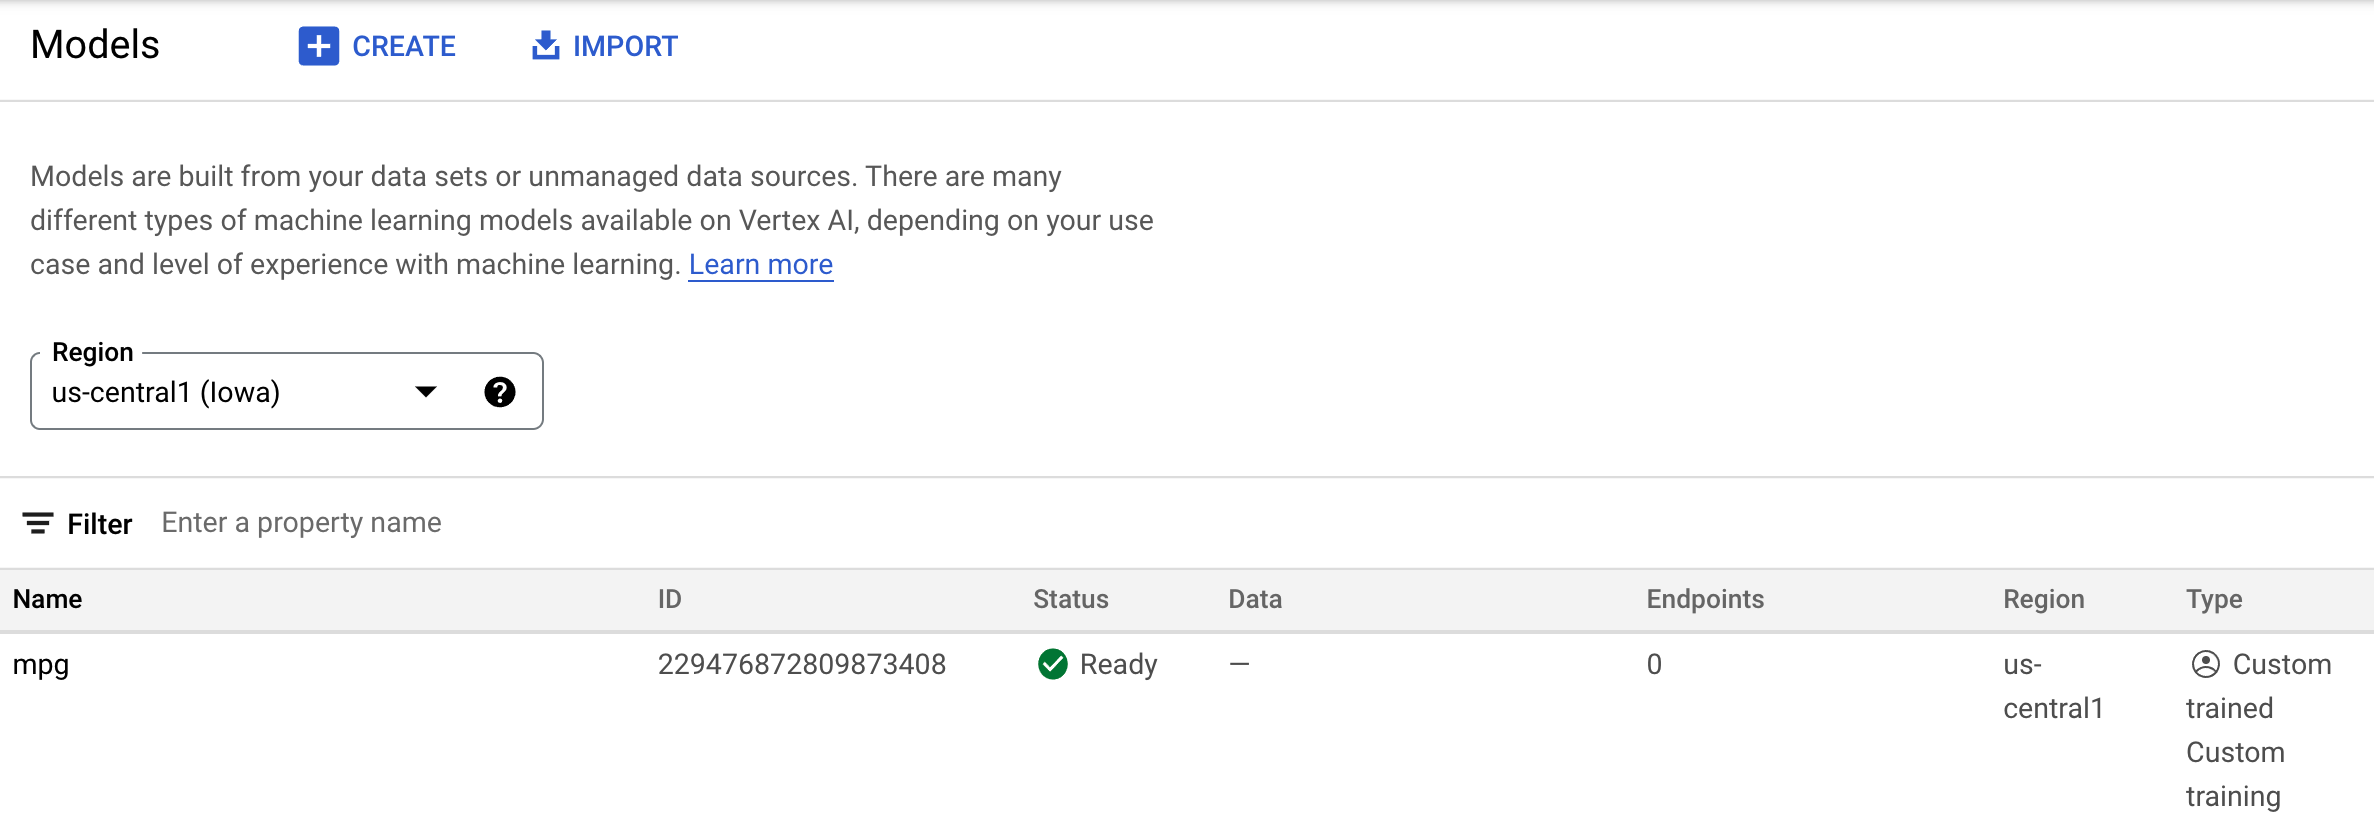



##### Step 2: Get predictions on the deployed  model

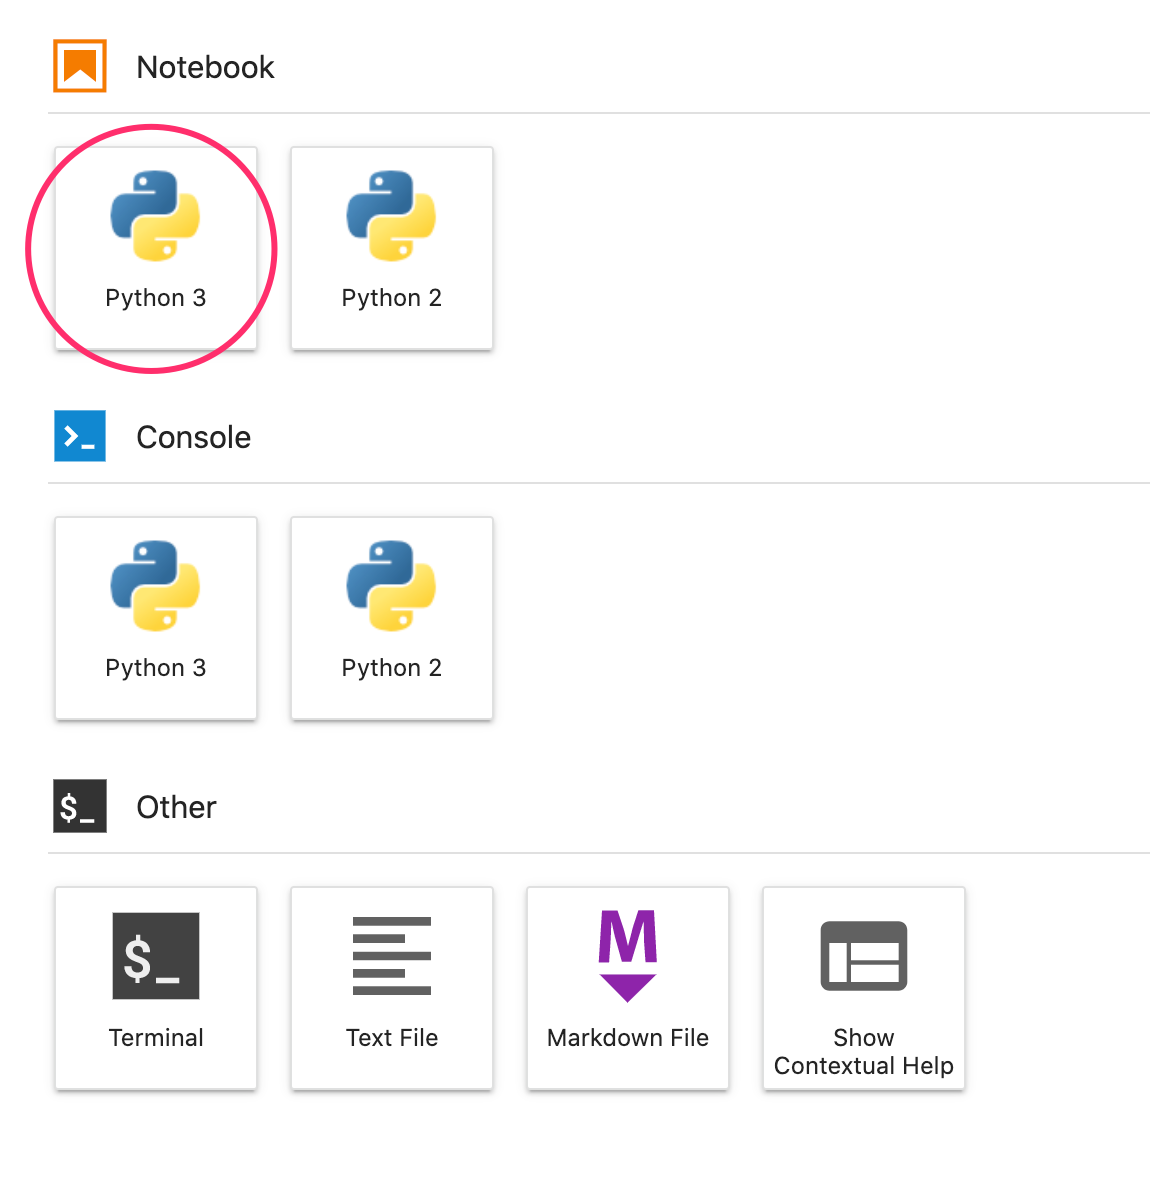

notebook에서 다음의 명령어 실행

```python
!pip3 install google-cloud-aiplatform --upgrade --user

from google.cloud import aiplatform

endpoint = aiplatform.Endpoint(
    endpoint_name="projects/YOUR-PROJECT-NUMBER/locations/us-central1/endpoints/YOUR-ENDPOINT-ID"
)
```

In [17]:
!pip3 install google-cloud-aiplatform --upgrade --user

In [18]:
from google.cloud import aiplatform

# endpoint = aiplatform.Endpoint(
#    endpoint_name="projects/PROJECT_ID/locations/us-central1/endpoints/ENDPOINT_ID"
# )

endpoint = aiplatform.Endpoint(
    endpoint_name="projects/507104XXXXXXX/locations/us-central1/endpoints/27514442123123123"
)
# 

In [19]:
test_mpg = [1.4838871833555929,
 1.8659883497083019,
 2.234620276849616,
 1.0187816540094903,
 -2.530890710602246,
 -1.6046416850441676,
 -0.4651483719733302,
 -0.4952254087173721,
 0.7746763768735953]

response = endpoint.predict([test_mpg])

print('API response: ', response)

print('Predicted MPG: ', response.predictions[0][0])

API response:  Prediction(predictions=[[16.2177448]], deployed_model_id='4901596448346341376', explanations=None)
Predicted MPG:  16.2177448
